# Notebook 3 – Clasificación Supervisada (Logistic Regression, Decision Tree, Random Forest)

      !  pip install numpy pandas scikit-learn nltk spacy gensim matplotlib seaborn unidecode

**Objetivo de la sesión (≈ 65 minutos):**  
Entrenar y comparar tres modelos de clasificación supervisada usando el dataset de *Bank Marketing*:

- Logistic Regression  
- Decision Tree  
- Random Forest  

Evaluaremos:

- Métricas: **accuracy, precision, recall, F1**  
- **Matriz de confusión**  
- Mini-desafío: elegir el mejor modelo y justificar su uso en un contexto tipo SISRED.

In [2]:
# 📦 1. Importar librerías

import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


## 2. Cargar el dataset

Archivo CSV se llama 'bank.csv'  que contiene
las siguientes columnas:

- `age`
- `job`
- `marital`
- `education`
- `default`
- `balance`
- `housing`
- `loan`
- `contact`
- `day`
- `month`
- `duration`
- `campaign`
- `pdays`
- `previous`
- `poutcome`
- `deposit`  ← **variable objetivo** (sí / no)



In [3]:
# 2.1 Cargar el dataset desde CSV
# Ajustar el nombre/ruta si es necesario: por ejemplo "./data/bank_marketing.csv"
df = pd.read_csv("bank.csv")

# Vista rápida de los primeros registros
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
# 2.2 Inspección general del dataframe
print("Dimensión del dataset:", df.shape)

print("\nInformación de columnas:")
df.info()

print("\nDistribución de la variable objetivo 'deposit':")
print(df['deposit'].value_counts())
print("\nDistribución relativa:")
print(df['deposit'].value_counts(normalize=True).round(3))


Dimensión del dataset: (11162, 17)

Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB

Distribución de la variable objetivo 

### Comentario rápido sobre el dataset

- Revisen cuántos registros y columnas tiene el dataset.
- Observen la distribución de `deposit`:
  - ¿Está balanceada (similar cantidad de 'yes' y 'no') o desbalanceada?
- Identifiquen cuáles variables son **numéricas** y cuáles son **categóricas**.

En un contexto real, esto impacta las decisiones de modelado y el tipo de métricas a priorizar.


## 3. Definir variables explicativas (X) y objetivo (y)

- `y` será la columna `deposit` (sí / no).
- `X` serán todas las demás columnas (sin `deposit`).

Luego haremos un **train/test split** para evaluar los modelos de forma justa.


In [5]:
# 3.1 Definir X e y
X = df.drop(columns=["deposit"])
y = df["deposit"]

# 3.2 Dividir en entrenamiento y prueba
# Usamos stratify=y para mantener la proporción de clases en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test :", X_test.shape)
print("Tamaño y_train:", y_train.shape)
print("Tamaño y_test :", y_test.shape)


Tamaño X_train: (7813, 16)
Tamaño X_test : (3349, 16)
Tamaño y_train: (7813,)
Tamaño y_test : (3349,)


## 4. Preprocesamiento: columnas numéricas vs categóricas

1. Identificaremos qué columnas son **numéricas** y cuáles son **categóricas**.  
2. Construiremos un `ColumnTransformer` que:
   - Aplique **StandardScaler** a las numéricas (útil para Logistic Regression).
   - Aplique **OneHotEncoder** a las categóricas (para transformar texto en variables binarias).

Luego reusaremos este preprocesador en los tres modelos.


In [6]:
# 4.1 Identificar columnas numéricas y categóricas
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Columnas numéricas:", numeric_features)
print("Columnas categóricas:", categorical_features)


Columnas numéricas: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Columnas categóricas: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [7]:
# 4.2 Definir transformaciones para cada tipo de variable

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",  # ignora categorías nuevas en test
    drop=None
)

# 4.3 ColumnTransformer que combina ambos
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)



## 5. Definir los tres modelos (pipelines)

Usaremos `Pipeline` para encadenar:

1. **Preprocesamiento** (ColumnTransformer)
2. **Modelo** (Logistic Regression, Decision Tree, Random Forest)

Así nos aseguramos de que el flujo sea consistente y reproducible.

Modelos:

- **Logistic Regression** (`LogisticRegression`)
- **Decision Tree** (`DecisionTreeClassifier`)
- **Random Forest** (`RandomForestClassifier`)


In [8]:
# 5.1 Definir los tres pipelines de modelos

log_reg_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LogisticRegression(max_iter=1000, n_jobs=-1))
    ]
)

tree_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", DecisionTreeClassifier(
            max_depth=6,       # limitamos profundidad para evitar sobreajuste extremo
            random_state=42
        ))
    ]
)

rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=150,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        ))
    ]
)


## 6. Entrenar modelos y obtener predicciones

Entrenaremos los tres modelos sobre `X_train, y_train` y luego predeciremos sobre `X_test`.

Guardaremos las predicciones en un diccionario para poder comparar fácilmente.


In [9]:
# 6.1 Entrenar modelos
log_reg_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# 6.2 Predicciones en el conjunto de prueba
y_pred_log = log_reg_model.predict(X_test)
y_pred_tree = tree_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)


c:\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


## 7. Evaluar modelos: accuracy, precision, recall, F1

Usaremos como clase positiva (`pos_label`) el valor `"yes"` de la variable `deposit`.

Calcularemos:

- `accuracy_score`
- `precision_score`
- `recall_score`
- `f1_score`

y luego los pondremos en un `DataFrame` para comparar.


In [10]:
# 7.1 Función auxiliar para calcular todas las métricas
def compute_metrics(y_true, y_pred, positive_label="yes"):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, pos_label=positive_label),
        "recall": recall_score(y_true, y_pred, pos_label=positive_label),
        "f1": f1_score(y_true, y_pred, pos_label=positive_label)
    }

# 7.2 Calcular métricas para cada modelo
metrics_log = compute_metrics(y_test, y_pred_log)
metrics_tree = compute_metrics(y_test, y_pred_tree)
metrics_rf = compute_metrics(y_test, y_pred_rf)

# 7.3 Crear un DataFrame con los resultados
results = pd.DataFrame(
    [metrics_log, metrics_tree, metrics_rf],
    index=["Logistic Regression", "Decision Tree", "Random Forest"]
)

results.round(3)


,accuracy,precision,recall,f1
Logistic Regression,0.826,0.830,0.795,0.812
Decision Tree,0.818,0.808,0.807,0.807
Random Forest,0.854,0.824,0.879,0.851


### 7.4 Visualización de métricas

Para tener una vista rápida, graficaremos las métricas (**accuracy, precision, recall, F1**) por modelo.


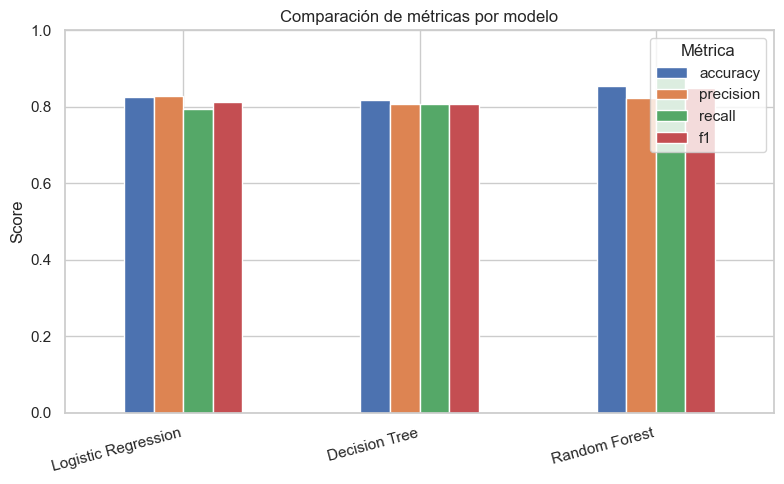

In [11]:
# 7.4 Visualizar métricas por modelo
results_plot = results.copy()
results_plot.plot(kind="bar")
plt.title("Comparación de métricas por modelo")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=15, ha="right")
plt.legend(title="Métrica")
plt.tight_layout()
plt.show()


## 8. Matriz de confusión

La matriz de confusión nos permite ver:

- Verdaderos positivos (TP)
- Verdaderos negativos (TN)
- Falsos positivos (FP)
- Falsos negativos (FN)

La interpretaremos especialmente para el modelo que mejor F1 obtenga (o el que el grupo elija).


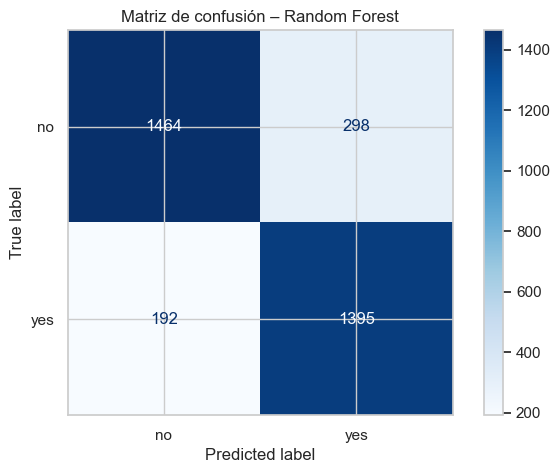

In [12]:
# 8.1 Elegir un modelo para mostrar la matriz de confusión
# Aquí tomamos por ejemplo el Random Forest (pueden cambiar a log_reg_model o tree_model)

y_pred_best = y_pred_rf  # cambiar si desean analizar otro modelo

cm = confusion_matrix(y_test, y_pred_best, labels=["no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["no", "yes"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión – Random Forest")
plt.show()


### Preguntas para discusión rápida

- ¿Qué es peor en este problema: un **falso positivo** o un **falso negativo**?  
- ¿Les importa más **precision** o **recall** en este contexto?  
- ¿Cómo cambia esa respuesta si el problema fuera SISRED (p.ej. detectar incidencias críticas vs. contactos de marketing)?  


## 10. Cierre del Notebook

En este notebook aprendimos a:

- Construir un pipeline de **preprocesamiento + modelo** usando `Pipeline` y `ColumnTransformer`.
- Entrenar y comparar tres modelos de clasificación supervisada:
  - Logistic Regression
  - Decision Tree
  - Random Forest
- Calcular métricas clave: **accuracy, precision, recall, F1**.
- Analizar una **matriz de confusión** y discutir implicancias prácticas.

Estos mismos conceptos se pueden trasladar a problemas reales de SISRED, por ejemplo:
- Clasificación de incidencias.
- Priorización de tickets.
- Segmentación de usuarios según probabilidad de respuesta/acción.

En la siguiente etapa podemos profundizar en **tuning de hiperparámetros**, validación cruzada y técnicas para manejar desbalance de clases.
